# Introduction to `DiscreteHandler`

In [20]:
import os
import sys
import yaml
import itertools as itt
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.abspath(""), ".."))

from infovar import DiscreteHandler, StandardGetter, prob_higher

## Context

Imagine you receive a box with two displays showing a numerical value. The box also has three knobs that can be turned to increase or decrease a value.

As it happens, you're not the only one to have received such a box. In fact, 6 of your colleagues have also received a similar box. There's just one detail that sets them apart: on their respective boxes, one or more knobs are hidden. This makes it impossible to read the value of these knobs and turn them. The boxes are as follows, no two identical:
- 3 boxes with one of the three knobs hidden,
- 3 boxes with two of the three knobs hidden,
- your box, with all knobs visible.

When you turn one of the knobs, and put your ear to it, you'll remark that the hidden knobs also turn, a priori randomly. Another important detail is that, even in the case of the box with all the knobs, two similar configurations never give exactly the same value on the screens, even though they are generally quite close.

![Boxes](img/boxes.png)

What you don't know is that these boxes have been sent to you by an impish statistician. The behavior of these boxes is actually governed by a simple non-deterministic mathematical formula:

$$ \begin{array}{c}y_1\\y_2\end{array} = \begin{array}{ll} (x_1-x_2)^2 + x_3 + \varepsilon_1 & \quad\text{s.t.}\quad\varepsilon_1\sim\mathcal{N}(0, 0.05)\\x_3^2 + \varepsilon_2 & \quad\text{s.t.}\quad\varepsilon_2\sim \mathcal{N}(0, 0.1)\end{array} $$

where $x_i$ is knob number $i$ and $y_j$ is display number $j$.

In [2]:
def function(
    x1: np.ndarray, x2: np.ndarray, x3: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    ci = cursor n°i (between -1 and 1)
    """
    assert x1.shape == x2.shape == x3.shape
    assert (
        (np.abs(x1) <= 1).all() and (np.abs(x2) <= 1).all() and (np.abs(x3) <= 1).all()
    )

    y1 = (x1 - x2) ** 2 + x3 + np.random.normal(0, 0.05, x1.shape)
    y2 = x3 ** 2 + np.random.normal(0, 0.1, x1.shape)
    return y1, y2

Your goal, and that of each of your colleagues, is to quantify the influence of the knobs on the displayed values. To do this, you will each note the values displayed by the screen, taking into account the known values of the knobs. Knob values will be sampled uniformly between -1 and 1.

## Getter

In this package, a "getter" is a function used to supply data meeting certain constraints. We provide a `StandardGetter` class that allows you to use samples already available and return a certain number via the `get` method. This method will be supplied to the handler.

In [3]:
n_samples = 50_000
x1 = np.random.uniform(-1, 1, n_samples)
x2 = np.random.uniform(-1, 1, n_samples)
x3 = np.random.uniform(-1, 1, n_samples)

y1, y2 = function(x1, x2, x3)

getter = StandardGetter(
    ["x1", "x2", "x3"],
    ["y1", "y2"],
    np.column_stack((x1, x2, x3)),
    np.column_stack((y1, y2)),
)

## Discrete handler

The `DiscreteHandler` is a tool that allows you to statistically analyze the influence of knobs on the values displayed on the screen.This class also manages the storage and access of these results.

In [4]:
handler = DiscreteHandler()

handler.set_path(os.path.join("handlers", "data"))
handler.set_getter(getter.get)

handler.overview()

DiscreteHandler
Save path: handlers
No existing saves.


In [5]:
# Remove existing saves if any
handler.remove("y1")
handler.remove("y2")

handler.overview()

DiscreteHandler
Save path: handlers
No existing saves.


In [6]:
with open(os.path.join("handlers", "restrictions.yaml"), "r") as f:
    restrictions = yaml.safe_load(f)

handler.set_restrictions(restrictions)

## First results

In [7]:
settings = {"restrictions": ["all"], "min_samples": 200, "max_samples": 10_000, "statistics": ["mi"]}

for s in ["y1", "y2"]:
    for c in ["x1", "x2", "x3"]:
        handler.overwrite(c, s, settings)

In [8]:
handler.overview() # Shows that save files has been created.

DiscreteHandler
Save path: handlers
Existing saves:
y1.json
y2.json


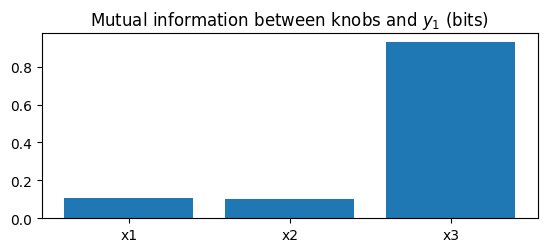

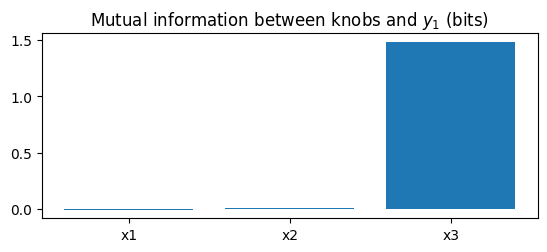

In [9]:
for screen in [1, 2]:

    items = handler.read(["x1", "x2", "x3"], f"y{screen}", "all", iterable_x=True)
    mis = [item["mi"]["value"] for item in items]

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, mis)
    plt.xticks(xticks, ["x1", "x2", "x3"])
    plt.title("Mutual information between knobs and $y_1$ (bits)")

    plt.show()

## Adding error bars

In [10]:
settings = {
    "restrictions": ["all"], "min_samples": 200, "max_samples": 10_000, "statistics": ["mi"],
    "uncertainty": {"mi": {"name": "subsampling"}}
}

for s in ["y1", "y2"]:
    for c in ["x1", "x2", "x3"]:
        handler.overwrite(c, s, settings)

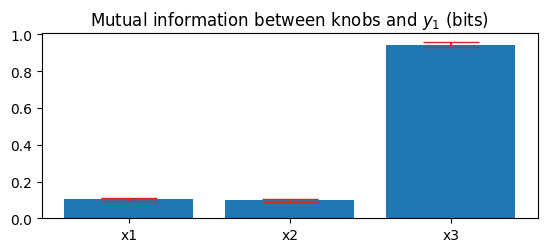

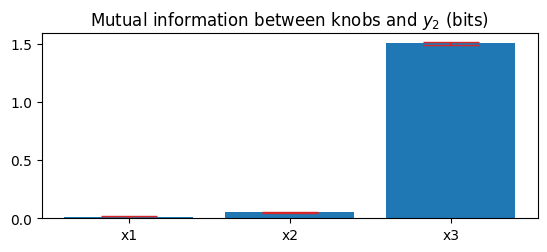

In [11]:
for screen in [1, 2]:

    items = handler.read(["x1", "x2", "x3"], f"y{screen}", "all", iterable_x=True)
    mis = [item["mi"]["value"] for item in items]
    stds = [item["mi"]["std"] for item in items]

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt="none", capsize=20, color="tab:red")
    plt.xticks(xticks, ["x1", "x2", "x3"])
    plt.title(f"Mutual information between knobs and $y_{screen}$ (bits)")

    plt.show()

## Comparison with other metrics

In this section, we compute the Pearson correlation coefficient to compare with mutual information.

In [12]:
settings = {
    "restrictions": ["all"], "min_samples": 200, "max_samples": 10_000, "statistics": ["corr"],
    "uncertainty": {"corr": {"name": "bootstrapping"}}
}

for s in ["y1", "y2"]:
    for c in ["x1", "x2", "x3"]:
        handler.overwrite(c, s, settings)

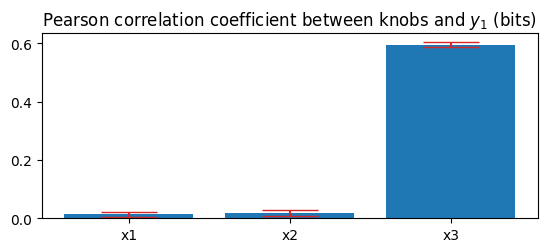

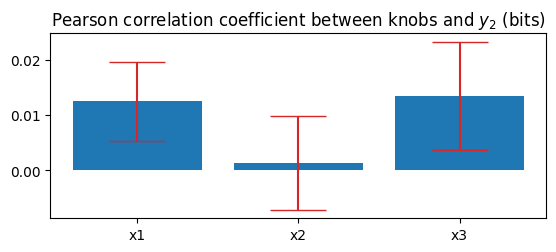

In [13]:
for screen in [1, 2]:

    items = handler.read(["x1", "x2", "x3"], f"y{screen}", "all", iterable_x=True)
    mis = [item["corr"]["value"] for item in items]
    stds = [item["corr"]["std"] for item in items]

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt="none", capsize=20, color="tab:red")
    plt.xticks(xticks, ["x1", "x2", "x3"])
    plt.title(f"Pearson correlation coefficient between knobs and $y_{screen}$ (bits)")

    plt.show()

We can see that the results are very different. This is notably due to the presence of square functions in the formulas.

The correlation coefficient can't capture all the statistical dependence if it's non-linear. For even relationships such as the square function, the correlation coefficient may even be zero, even though there is statistical dependence.

## Influence of combined knobs

In [14]:
settings = {
    "restrictions": ["all"], "min_samples": 200, "max_samples": 10_000, "statistics": ["mi"],
    "uncertainty": {"mi": {"name": "subsampling"}}
}

variables = ["x1", "x2", "x3"]\
    + list(itt.combinations(["x1", "x2", "x3"], 2))\
    + list(itt.combinations(["x1", "x2", "x3"], 3))

for s in ["y1", "y2"]:
    handler.overwrite(variables, s, settings, iterable_x=True)

[y2]: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s, x=[x3, x2, x1]]


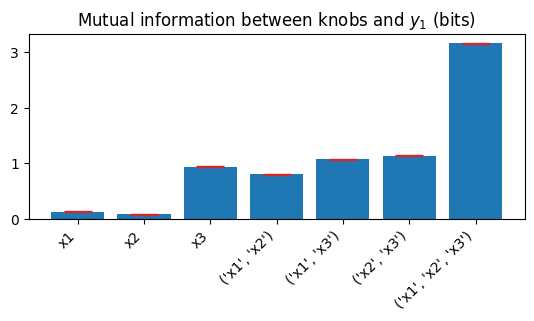

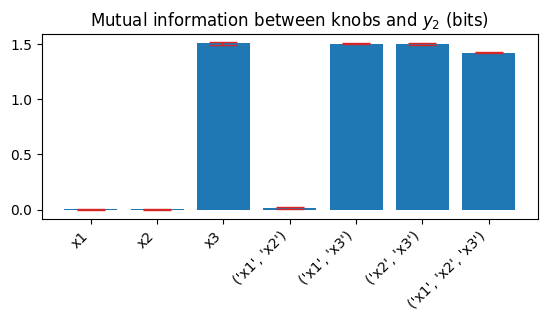

In [15]:
for screen in [1, 2]:

    items = handler.read(variables, f"y{screen}", "all", iterable_x=True)
    mis = [item["mi"]["value"] for item in items]
    stds = [item["mi"]["std"] for item in items]

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt="none", capsize=10, color="tab:red")
    plt.xticks(xticks, variables, rotation=45, horizontalalignment="right")
    plt.title(f"Mutual information between knobs and $y_{screen}$ (bits)")

    plt.show()

The mutual information provided by knowing all three knobs simultaneously gives less information than knowing just two of them. This result runs counter to information theory, since knowledge of an additional variable should not reduce mutual information. In the worst case, this variable is independent of the data of interest, so the information gain is zero.

In fact, this is only a consequence of the `max_samples` sample limitation. This parameter limits calculation time by avoiding the use of all available samples. However, when the number of combined variables becomes large, more samples are needed to estimate the mutual information without bias.

## Computation with more samples

In this section, we set the `max_sample`parameter to None, which means that all available data is used. Note that in general, this is a bad practice, since using all available data can lead to very long calculation times for negligible gains in accuracy.

In [16]:
settings = {
    "restrictions": ["all"], "min_samples": 200, "max_samples": None, "statistics": ["mi"],
    "uncertainty": {"mi": {"name": "subsampling"}}
}

variables = ["x1", "x2", "x3"]\
    + list(itt.combinations(["x1", "x2", "x3"], 2))\
    + list(itt.combinations(["x1", "x2", "x3"], 3))

for s in ["y1", "y2"]:
    handler.update(variables, s, settings, iterable_x=True) # Update to avoid recalculating result for indivual variables

[y2]: 100%|██████████| 7/7 [00:00<00:00, 430.99it/s, x=[x3, x2, x1]]


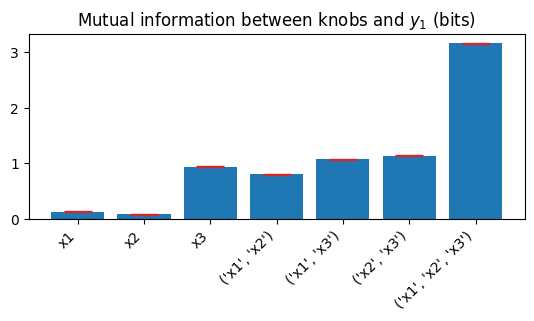

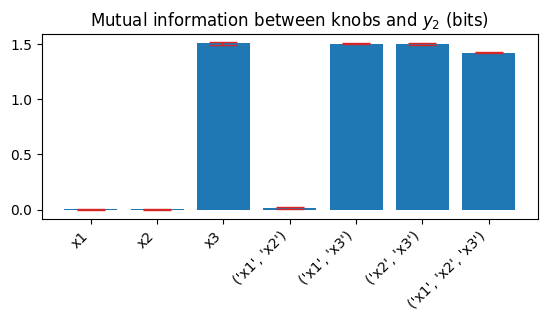

In [17]:
for screen in [1, 2]:

    items = handler.read(variables, f"y{screen}", "all", iterable_x=True)
    mis = [item["mi"]["value"] for item in items]
    stds = [item["mi"]["std"] for item in items]

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt="none", capsize=10, color="tab:red")
    plt.xticks(xticks, variables, rotation=45, horizontalalignment="right")
    plt.title(f"Mutual information between knobs and $y_{screen}$ (bits)")

    plt.show()

## Restrictions on screen values

In this section, we set up a case distinction. We want to know whether knobs can be used to constrain the values of the first screen if the latter is positive or negative. Are some knobs more important in one case than the other?

In [18]:
settings = {
    "restrictions": ["positive_1", "negative_1"], "min_samples": 200, "max_samples": None, "statistics": ["mi"],
    "uncertainty": {"mi": {"name": "subsampling"}}
}

variables = ["x1", "x2", "x3"]\
    + list(itt.combinations(["x1", "x2", "x3"], 2))\
    + list(itt.combinations(["x1", "x2", "x3"], 3))

for s in ["y1", "y2"]:
    handler.overwrite(variables, s, settings, iterable_x=True)

[y2]: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it, x=[x3, x2, x1]]


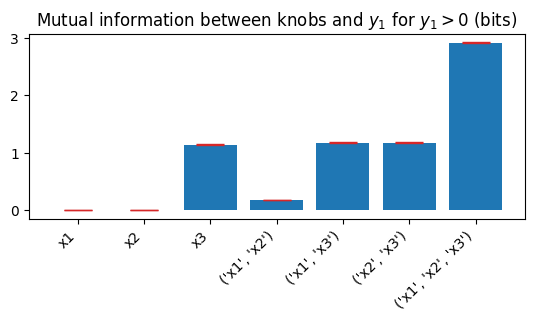

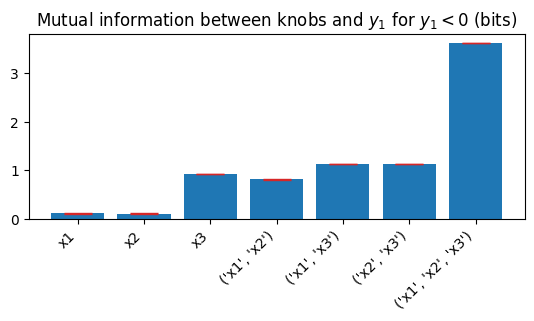

In [19]:
for restr in ["positive_1", "negative_1"]:

    items = handler.read(variables, "y1", restr, iterable_x=True)
    mis = [item["mi"]["value"] for item in items]
    stds = [item["mi"]["std"] for item in items]

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt="none", capsize=10, color="tab:red")
    plt.xticks(xticks, variables, rotation=45, horizontalalignment="right")
    if restr.startswith("positive"):
        plt.title(f"Mutual information between knobs and $y_1$ for $y_1 > 0$ (bits)")
    else:
        plt.title(f"Mutual information between knobs and $y_1$ for $y_1 < 0$ (bits)")

    plt.show()

It can be seen that higher amounts of information are achieved when the value is negative than when it is positive, which means that on average it will be simpler to constrain the possible values of the screen when it is negative than when it is positive.

We also note that the couple $(x_1, x_2)$ is not very informative in the case of a positive screen value, but rather informative in the opposite case.

## Probability of a set of knobs to be the most informative one

In [23]:
variables = ["x1", "x2", "x3"] + list(itt.combinations(["x1", "x2", "x3"], 2))

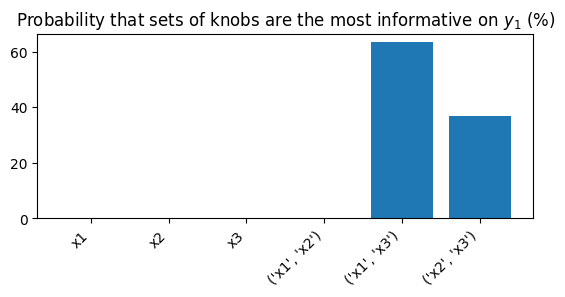

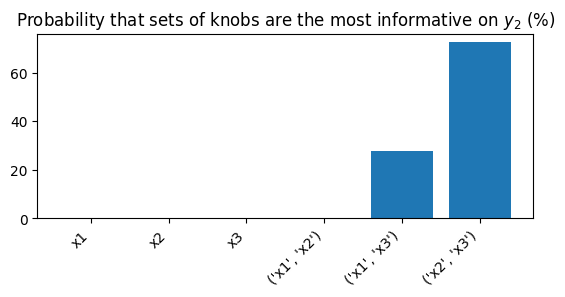

In [25]:
for screen in [1, 2]:

    items = handler.read(variables, f"y{screen}", restr, iterable_x=True)
    mis = [item["mi"]["value"] for item in items]
    stds = [item["mi"]["std"] for item in items]

    probs = 100 * prob_higher(mis, stds)

    plt.figure(figsize=(6.4, 0.5 * 4.8))

    xticks = np.arange(len(mis))
    plt.bar(xticks, probs)
    plt.xticks(xticks, variables, rotation=45, horizontalalignment="right")
    plt.title(f"Probability that sets of knobs are the most informative on $y_{screen}$ (%)")

    plt.show()